# Assignment 1
## Tommy Jun (tbj2cu)

# Create Context

In [1]:
from os import listdir
from os.path import isfile, join
import boto3
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType
import pandas as pd 
import pyspark
import pyspark.sql.functions as sf

In [2]:
# Initialize
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)

# Parquet

In [3]:
# Set S3 bucket
s3 = boto3.resource("s3")

In [4]:
# Pull data as spark dataframe
bucket = "odl-spark19spds6003-001"
data_key = "sample_data/pqt/food-inspections.csv"
data_location = 's3://{}/{}'.format(bucket, data_key)
df = pd.read_csv(data_location)

# Drop NA to clear up errors
df = df.dropna()

# Convert DF to Spark DF
df = sqlc.createDataFrame(df)

In [5]:
# Let's check the schema
df.printSchema()

root
 |-- Inspection ID: long (nullable = true)
 |-- DBA Name: string (nullable = true)
 |-- AKA Name: string (nullable = true)
 |-- License #: double (nullable = true)
 |-- Facility Type: string (nullable = true)
 |-- Risk: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zip: double (nullable = true)
 |-- Inspection Date: string (nullable = true)
 |-- Inspection Type: string (nullable = true)
 |-- Results: string (nullable = true)
 |-- Violations: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [6]:
# Spark DF
df

DataFrame[Inspection ID: bigint, DBA Name: string, AKA Name: string, License #: double, Facility Type: string, Risk: string, Address: string, City: string, State: string, Zip: double, Inspection Date: string, Inspection Type: string, Results: string, Violations: string, Latitude: double, Longitude: double, Location: string]

In [7]:
# Clean up, rename to remove errors
df = df.withColumnRenamed("Inspection ID", "ID")
df = df.withColumnRenamed("DBA Name","DBA")
df = df.withColumnRenamed("AKA Name","AKA")
df = df.withColumnRenamed("License #","License")
df = df.withColumnRenamed("Facility type","Facility")
df = df.withColumnRenamed("Inspection Date","InspectionDate")
df = df.withColumnRenamed("Inspection Type","InspectionType")

In [8]:
# Write Parquet file
parquetPath = r"/home/ec2-user/SageMaker/tbj2cu/temp-8-pqt"
df.write.parquet(parquetPath)

In [9]:
# Get ready to move files into s3 bucket
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

In [10]:
# Check files
files

['part-00000-0c0a64c3-a120-4728-85ab-36a451fe1a04-c000.snappy.parquet',
 '.part-00000-0c0a64c3-a120-4728-85ab-36a451fe1a04-c000.snappy.parquet.crc',
 '._SUCCESS.crc',
 '_SUCCESS']

In [11]:
# Copy to bucket
for f in files:
    print('copying {} to {}'.format(parquetPath+'/'+f,"sample_data/"+f))
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "sample_data/pqt/"+f)

copying /home/ec2-user/SageMaker/tbj2cu/temp-8-pqt/part-00000-0c0a64c3-a120-4728-85ab-36a451fe1a04-c000.snappy.parquet to sample_data/part-00000-0c0a64c3-a120-4728-85ab-36a451fe1a04-c000.snappy.parquet
copying /home/ec2-user/SageMaker/tbj2cu/temp-8-pqt/.part-00000-0c0a64c3-a120-4728-85ab-36a451fe1a04-c000.snappy.parquet.crc to sample_data/.part-00000-0c0a64c3-a120-4728-85ab-36a451fe1a04-c000.snappy.parquet.crc
copying /home/ec2-user/SageMaker/tbj2cu/temp-8-pqt/._SUCCESS.crc to sample_data/._SUCCESS.crc
copying /home/ec2-user/SageMaker/tbj2cu/temp-8-pqt/_SUCCESS to sample_data/_SUCCESS


In [12]:
# Read from bucket
temp = sqlc.read.parquet(parquetPath)

In [13]:
# Check to make sure we can read it from the bucket correctly
temp

DataFrame[ID: bigint, DBA: string, AKA: string, License: double, Facility: string, Risk: string, Address: string, City: string, State: string, Zip: double, InspectionDate: string, InspectionType: string, Results: string, Violations: string, Latitude: double, Longitude: double, Location: string]

In [14]:
# I tried some things with schemas but there were some errors
"""
role = get_execution_role()
schema = StructType([
    StructField("Inspection ID", IntegerType(), True),
    StructField("DBA Name", StringType(), True),
    StructField("AKA Name", StringType(), True),
    StructField("License #", IntegerType(), True),
    StructField("Facility Type", StringType(), True),
    StructField("Risk", StringType(), True),
    StructField("Address", StringType(), True),
    StructField("City", StringType(), True),
    StructField("State", StringType(), True),
    StructField("Zip", IntegerType(), True),
    StructField("Inspection Date", StringType(), True), # <<<
    StructField("Inspection Type", StringType(), True),
    StructField("Results", StringType(), True),
    StructField("Violations", StringType(), True),
    StructField("Latitude", StringType(), True), # <<<
    StructField("Longitude", StringType(), True), # <<<
    StructField("Location", StringType(), True)
])
"""

'\nrole = get_execution_role()\nschema = StructType([\n    StructField("Inspection ID", IntegerType(), True),\n    StructField("DBA Name", StringType(), True),\n    StructField("AKA Name", StringType(), True),\n    StructField("License #", IntegerType(), True),\n    StructField("Facility Type", StringType(), True),\n    StructField("Risk", StringType(), True),\n    StructField("Address", StringType(), True),\n    StructField("City", StringType(), True),\n    StructField("State", StringType(), True),\n    StructField("Zip", IntegerType(), True),\n    StructField("Inspection Date", StringType(), True), # <<<\n    StructField("Inspection Type", StringType(), True),\n    StructField("Results", StringType(), True),\n    StructField("Violations", StringType(), True),\n    StructField("Latitude", StringType(), True), # <<<\n    StructField("Longitude", StringType(), True), # <<<\n    StructField("Location", StringType(), True)\n])\n'

# MLlib/Visualization

In [15]:
# Let's check the df
display(df)

DataFrame[ID: bigint, DBA: string, AKA: string, License: double, Facility: string, Risk: string, Address: string, City: string, State: string, Zip: double, InspectionDate: string, InspectionType: string, Results: string, Violations: string, Latitude: double, Longitude: double, Location: string]

In [16]:
df.printSchema()

root
 |-- ID: long (nullable = true)
 |-- DBA: string (nullable = true)
 |-- AKA: string (nullable = true)
 |-- License: double (nullable = true)
 |-- Facility: string (nullable = true)
 |-- Risk: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zip: double (nullable = true)
 |-- InspectionDate: string (nullable = true)
 |-- InspectionType: string (nullable = true)
 |-- Results: string (nullable = true)
 |-- Violations: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [17]:
df.take(5)

[Row(ID=2240307, DBA='2 POTZ & A PAN EATERY', AKA='2 POTZ & A PAN EATERY', License=2626283.0, Facility='Restaurant', Risk='Risk 1 (High)', Address='6052 S EBERHART AVE ', City='CHICAGO', State='IL', Zip=60637.0, InspectionDate='2018-11-16T00:00:00', InspectionType='License', Results='Pass w/ Conditions', Violations="3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: OBSERVED NO EMPLOYEE HEALTH POLICY AVAILABLE. INSTRUCTED MANAGER TO PROVIDE EMPLOYEE HEALTH POLICY. PRIORITY FOUNDATION 7-38-012(A) | 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: OBSERVED NO CLEAN UP POLICY FOR VOMITING OR DIARRHEAL EVENTS. INSTRUCTED MANAGER TO PROVIDE CLEAN UP POLICY. PRIORITY FOUNDATION 7-38-005 | 10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: OBSERVED NO HAND WASHING SIGNS AT HAND WASHING SINKS IN PREP AND WASHROOM AREAS. INSTRUCTED MANAGER TO PROVIDE HAND WASHING SIGNS AT ALL HAND WASHING

In [18]:
# Get categories for risk
# cats = df.select("Risk").distinct().rdd.flatMap(lambda x: x).collect()
cats = ["Risk 1 (High)", "Risk 2 (Medium)", "Risk 3 (Low)"]

In [19]:
# https://stackoverflow.com/questions/46528207/dummy-encoding-using-pyspark
exp = [sf.when(sf.col("Risk") == cat, 1).otherwise(0)\
      .alias(str(cat)) for cat in cats]
df_dummy = df.select(exp+df.columns)

In [20]:
df.select(exp)

DataFrame[Risk 1 (High): int, Risk 2 (Medium): int, Risk 3 (Low): int]

In [21]:
# Get the columns 
# https://stackoverflow.com/questions/46813283/select-columns-in-pyspark-dataframe
pdf = df_dummy.select([c for c in df_dummy.columns if c in ["Latitude", "Longitude", "Risk 1 (High)", "Risk 2 (Medium)", "Risk 3 (Low)"]])

In [22]:
pdf.show(2)

+-------------+---------------+------------+------------------+------------------+
|Risk 1 (High)|Risk 2 (Medium)|Risk 3 (Low)|          Latitude|         Longitude|
+-------------+---------------+------------+------------------+------------------+
|            1|              0|           0|41.784183106202434|-87.61338492635632|
|            1|              0|           0|41.844544292008855|-87.71107279676546|
+-------------+---------------+------------+------------------+------------------+
only showing top 2 rows



In [23]:
pdf = pdf.toPandas()
pdf.head(2)

Risk 1 (High)  Risk 2 (Medium)  Risk 3 (Low)   Latitude  Longitude
0              1                0             0  41.784183 -87.613385
1              1                0             0  41.844544 -87.711073

In [24]:
# https://matplotlib.org/users/legend_guide.html
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [25]:
cols = pdf["Risk 1 (High)"]+2*pdf["Risk 2 (Medium)"]+3*pdf["Risk 3 (Low)"]
pdf["Color"] = 0
pdf.loc[cols==1,"Color"] = "tomato"
pdf.loc[cols==2,"Color"] = "darkorange"
pdf.loc[cols==3,"Color"] = "darkgreen"

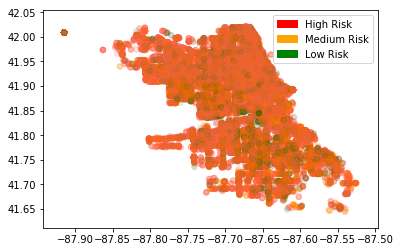

In [26]:
red = mpatches.Patch(color="red", label="High Risk")
orange = mpatches.Patch(color="orange", label="Medium Risk")
green = mpatches.Patch(color="green", label="Low Risk")

plt.scatter(pdf.Longitude, pdf.Latitude, c=pdf.Color, alpha=0.05, s=30)
plt.legend(handles=[red, orange, green])
plt.rcParams["figure.dpi"] = 144
plt.show()

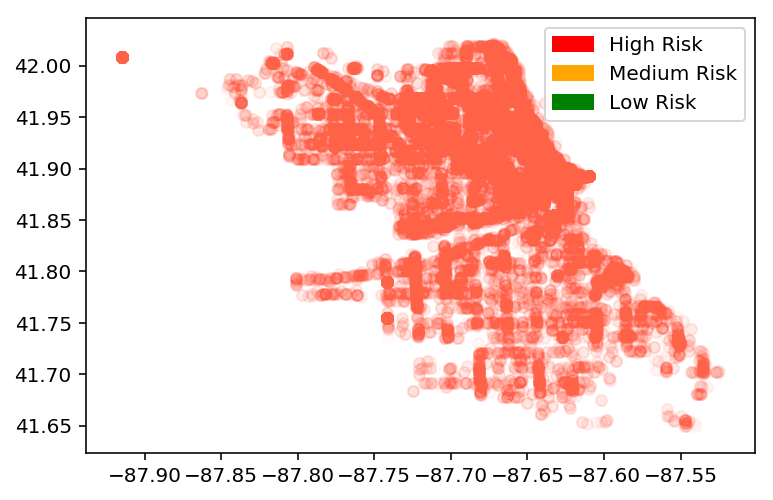

In [28]:
plt.scatter(pdf.Longitude[cols==1], pdf.Latitude[cols==1], c="tomato", alpha=0.01, s=30)
plt.legend(handles=[red, orange, green])
plt.rcParams["figure.dpi"] = 144
plt.show()

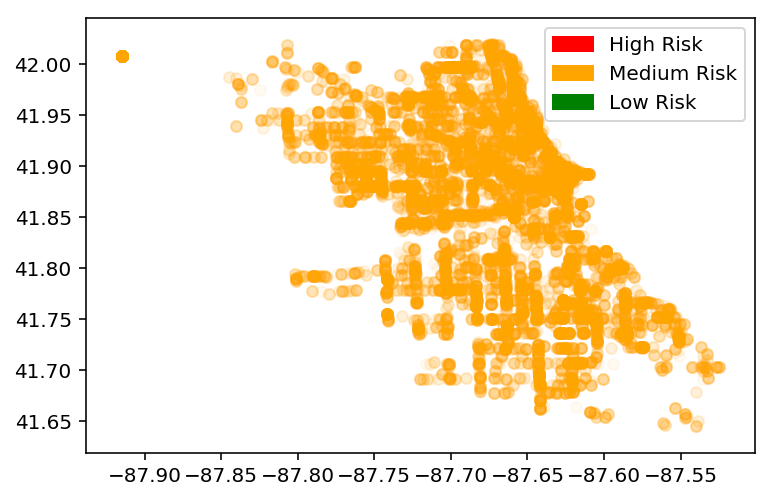

In [28]:
plt.scatter(pdf.Longitude[cols==2], pdf.Latitude[cols==2], c="orange", alpha=0.05, s=30)
plt.legend(handles=[red, orange, green])
plt.rcParams["figure.dpi"] = 144
plt.show()

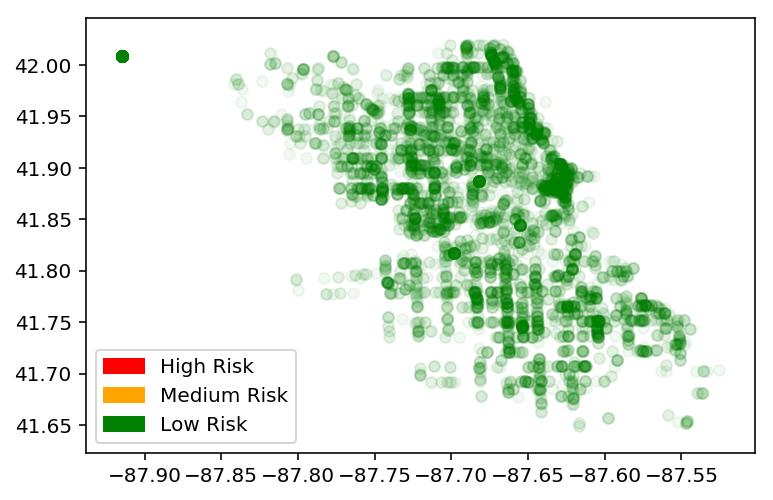

In [29]:
plt.scatter(pdf.Longitude[cols==3], pdf.Latitude[cols==3], c="green", alpha=0.05, s=30)
plt.legend(handles=[red, orange, green])
plt.rcParams["figure.dpi"] = 144
plt.show()

In [30]:
df_select = df_dummy.select("Risk","Longitude","Latitude")

In [31]:
# Split
seed = 4.669
test, train = df_select.randomSplit([0.20, 0.80], seed=seed)

In [32]:
# Vectorize
from pyspark.ml.linalg import Vectors, VectorUDT

sqlc.registerFunction("twoElementVec", lambda x, y: Vectors.dense([x, y]), returnType=VectorUDT())

# Vectorize the data frames
trainingDF = train.selectExpr("Risk", "twoElementVec(Longitude, Latitude) as Coords")
testDF = test.selectExpr("Risk", "twoElementVec(Longitude, Latitude) as Coords")

trainingDF = trainingDF.withColumnRenamed("Risk", "label").withColumnRenamed("Coords", "features")
testDF = testDF.withColumnRenamed("Risk", "label").withColumnRenamed("Coords", "features")

testDF.limit(5).show()

+-------------+--------------------+
|        label|            features|
+-------------+--------------------+
|Risk 1 (High)|[-87.914428439270...|
|Risk 1 (High)|[-87.914428439270...|
|Risk 1 (High)|[-87.914428439270...|
|Risk 1 (High)|[-87.914428439270...|
|Risk 1 (High)|[-87.914428439270...|
+-------------+--------------------+



In [33]:
import pyspark.sql.functions as F
import pyspark.sql.types as T

dic = {"Risk 1 (High)":1,
       "Risk 2 (Medium)":0,
       "Risk 3 (Low)":0}

def mapr(dict_key):
    return dic[dict_key]

my_udf = F.UserDefinedFunction(mapr, T.IntegerType())

In [34]:
trainingDF = trainingDF.withColumn("label", my_udf("label"))
testDF = testDF.withColumn("label", my_udf("label"))

In [35]:
testDF.limit(5).show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|[-87.914428439270...|
|    1|[-87.914428439270...|
|    1|[-87.914428439270...|
|    1|[-87.914428439270...|
|    1|[-87.914428439270...|
+-----+--------------------+



In [48]:
# I tried subsetting the data because it was taking too long
subset = testDF.limit(10)

In [49]:
from pyspark.ml.classification import LogisticRegression

In [50]:
lr = LogisticRegression(maxIter=5, regParam=0.3, elasticNetParam=0.8)

In [51]:
# This step is the one that's taking too long

lrModel = lr.fit(subset)

KeyboardInterrupt: 

In [34]:
type(lrModel)

pyspark.ml.classification.LogisticRegressionModel

In [35]:
predictionsAndLabelsDF = lrModel.transform(testDF)

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(label=1, features=DenseVector([-87.9144, 42.0085]), rawPrediction=DenseVector([-inf, inf]), probability=DenseVector([0.0, 1.0]), prediction=1.0), Row(label=1, features=DenseVector([-87.9144, 42.0085]), rawPrediction=DenseVector([-inf, inf]), probability=DenseVector([0.0, 1.0]), prediction=1.0), Row(label=1, features=DenseVector([-87.9144, 42.0085]), rawPrediction=DenseVector([-inf, inf]), probability=DenseVector([0.0, 1.0]), prediction=1.0), Row(label=1, features=DenseVector([-87.9144, 42.0085]), rawPrediction=DenseVector([-inf, inf]), probability=DenseVector([0.0, 1.0]), prediction=1.0), Row(label=1, features=DenseVector([-87.9144, 42.0085]), rawPrediction=DenseVector([-inf, inf]), probability=DenseVector([0.0, 1.0]), prediction=1.0)]


In [ ]:
# Model Evaluation
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator()
print(eval.explainParams())

In [ ]:
type(eval)

In [ ]:
eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)

In [ ]:
eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)

In [33]:
"""
Everything below here are attempts to do kNN classification but it isn't supported in pyspark
"""
# Let's do the ML now
from sklearn.neighbors import NearestNeighbors

In [ ]:
trainingDF.selectExpr("Coord").show(2)

In [ ]:
trainCoords = trainingDF.selectExpr("Coord").toPandas()
trainTarget = trainingDF.selectExpr("Risk").toPandas()

In [ ]:
trainCoords.head(2)
trainTarget.head(2)

In [ ]:
# Adapted from
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 10

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = trainCoords
y = trainTarget

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [ ]:
X = pd.DataFrame(data={
    "X":[x[0] for x in X[0]],
    "Y":[x[1] for x in X[0]]
})

In [ ]:
clf = neighbors.KNeighborsClassifier(n_neighbors, weights="distance")
clf.fit(X, y.values.ravel())

In [ ]:
x_min, x_max = X.X.min() - 1, X.X.max() + 1
y_min, y_max = X.Y.min() - 1, X.Y.max() + 1

In [ ]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

In [ ]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

In [ ]:
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i, weights = '%s')"% (n_neighbors, weights))

plt.show()

In [ ]:
X[:,:2]

In [ ]:
plt.scatter(xx,yy, alpha=0.01)